In [2]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold,StratifiedKFold
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import random
import re
import torch
import joblib

In [2]:
fname = './data/processed/KPCD3_processed_ac.csv'
df = pd.read_csv(fname)

In [3]:
p_mask = df['label'] == 1
n_mask = df['label'] == 0
print(sum(p_mask))
print(sum(n_mask))

68
41


In [4]:
seed = 10
random.seed(seed)
np.random.seed(seed)
df_mix = pd.concat([df[p_mask].sample(41),df[n_mask].sample(41)])
# df_mix = pd.concat([df[p_mask],df[n_mask]])

In [5]:
df_mix = df_mix.sample(frac=1)

In [6]:
smiles_list = df_mix['smiles'].values
y = df_mix['label'].values
sum(y==1)

41

In [7]:
x = []
for smiles in smiles_list:
    mol=Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    # fp_bits = fp.ToBitString()
    fp_bits = fp.ToList()
    x.append(fp_bits)
x = np.array(x)
x.shape

(82, 167)

In [8]:
for s in range(242,243):
    sfolder = StratifiedKFold(n_splits=3,random_state=s,shuffle=True)
    splits = list(sfolder.split(x,y))

    f1_list = []
    precision_list =  []
    for train, test in sfolder.split(x,y):
        regr = make_pipeline(SVC(probability = True))
        regr.fit(x[train], y[train])
        pred = regr.predict(x[test])
        f1 = f1_score(y[test].reshape(-1,1), pred.reshape(-1,1), average='micro')
        p_score = precision_score(y[test], pred, average='micro')
        f1_list.append(f1)
        precision_list.append(p_score)
        print(f"f1: {f1}; precision: {p_score}.")

    f1_ts = torch.Tensor(f1_list)
    precision_ts = torch.Tensor(precision_list)

    print("=======>",s)
    print(f"F1 mean: {f1_ts.mean()}, std: {f1_ts.std()}.")
    print(f"Precision mean: {precision_ts.mean()}, std: {precision_ts.std()}.")



f1: 0.42857142857142855; precision: 0.42857142857142855.
f1: 0.7407407407407407; precision: 0.7407407407407407.
f1: 0.6296296296296297; precision: 0.6296296296296297.
=======> 242
F1 mean: 0.5996472239494324, std: 0.15822964906692505.
Precision mean: 0.5996472239494324, std: 0.15822964906692505.


In [ ]:
idx = 1
train = splits[idx][0]
test = splits[idx][1]

regr = make_pipeline(SVC(probability = True))
regr.fit(x[train], y[train])
pred = regr.predict(x[test])
f1 = f1_score(y[test].reshape(-1,1), pred.reshape(-1,1), average='micro')
p_score = precision_score(y[test], pred, average='micro')
f1_list.append(f1)
precision_list.append(p_score)
print(f"f1: {f1}; precision: {p_score}.")

joblib.dump(regr, "SVC.m")

# 加入额外的数据

In [9]:
df_positive = pd.read_csv('./data/positive.csv')
smiles_positive = df_positive['smiles'].values
y_positive = df_positive['label'].values

df_negtive = pd.read_csv('./data/negtive.csv')
smiles_negtive = df_negtive['smiles'].values
y_negtive = df_negtive['label'].values

In [10]:
x_positive = []
y_positive = []
################# 正样本
for smiles in smiles_positive:
    mol=Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    # fp_bits = fp.ToBitString()
    fp_bits = fp.ToList()
    x_positive.append(fp_bits)
    y_positive.append(1)
x_positive = np.array(x_positive)
y_positive = np.array(y_positive)

x_negtive = []
y_negtive = []
################# 负样本
for smiles in smiles_negtive:
    mol=Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    # fp_bits = fp.ToBitString()
    fp_bits = fp.ToList()
    x_negtive.append(fp_bits)
    y_negtive.append(0)
x_negtive = np.array(x_negtive)
y_negtive = np.array(y_negtive)

print(len(x_positive))
print(len(x_negtive))

277
1029


In [11]:
idx_positive = [i for i in range(len(x_positive))]
idx_negtive = [i for i in range(len(x_negtive))]

In [12]:
sample_list = [5,10,15,20,25,30,35,40,45,50]

f1_score_mean = []
f1_score_std = []
for sample_num in sample_list:
    random.seed(100)

    idx_p = random.sample(idx_positive, sample_num)
    idx_n = random.sample(idx_negtive, sample_num)

    x_extra = np.concatenate([x_positive[idx_p],x_negtive[idx_n]])
    y_extra = np.concatenate([y_positive[idx_p],y_negtive[idx_n]])

    idx_s = [i for i in range(len(y_extra))]
    random.shuffle(idx_s)
    x_extra = x_extra[idx_s]
    y_extra = y_extra[idx_s]

    f1_list = []
    precision_list =  []
    for train, test in sfolder.split(x,y):
        regr = make_pipeline(SVC(probability = True))
        regr.fit(np.concatenate([x[train], x_extra]), np.concatenate([y[train], y_extra]))
        pred = regr.predict(x[test])
        f1 = f1_score(y[test].reshape(-1,1), pred.reshape(-1,1), average='micro')
        p_score = precision_score(y[test], pred, average='micro')

        f1_list.append(f1)
        precision_list.append(p_score)
        # print(f"f1: {f1}; precision: {p_score}.")

    f1_ts = torch.Tensor(f1_list)
    precision_ts = torch.Tensor(precision_list)

    f1_score_mean.append(round(f1_ts.mean().item(),4))
    f1_score_std.append(round(f1_ts.std().item(),4))

print(f1_score_mean)
print(f1_score_std)

[0.6239, 0.6481, 0.6235, 0.6609, 0.6609, 0.6358, 0.6596, 0.6473, 0.6477, 0.6354]
[0.1431, 0.1296, 0.1205, 0.1713, 0.1713, 0.1176, 0.0764, 0.0682, 0.097, 0.0883]


In [13]:
sample_list = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

f1_score_mean = []
f1_score_std = []

idx = 2
train = splits[idx][0]
test = splits[idx][1]

for sample_num in sample_list:
    f1_list = []
    precision_list =  []
    for seed in range(0,100):

        random.seed(seed)

        idx_p = random.sample(idx_positive, sample_num)
        idx_n = random.sample(idx_negtive, sample_num)

        x_extra = np.concatenate([x_positive[idx_p],x_negtive[idx_n]])
        y_extra = np.concatenate([y_positive[idx_p],y_negtive[idx_n]])

        idx_s = [i for i in range(len(y_extra))]
        random.shuffle(idx_s)
        x_extra = x_extra[idx_s]
        y_extra = y_extra[idx_s]

        regr = make_pipeline(SVC(probability = True))
        regr.fit(np.concatenate([x[train], x_extra]), np.concatenate([y[train], y_extra]))
        pred = regr.predict(x[test])
        f1 = f1_score(y[test].reshape(-1,1), pred.reshape(-1,1), average='micro')
        p_score = precision_score(y[test], pred, average='micro')

        f1_list.append(f1)
        precision_list.append(p_score)
        # print(f"f1: {f1}; precision: {p_score}.")

    f1_ts = torch.Tensor(f1_list)
    precision_ts = torch.Tensor(precision_list)

    f1_score_mean.append(round(f1_ts.mean().item(),4))
    f1_score_std.append(round(f1_ts.std().item(),4))

print(f1_score_mean)
print(f1_score_std)

[0.6896, 0.7178, 0.7422, 0.7552, 0.7611, 0.7648, 0.7622, 0.7644, 0.7659, 0.7648, 0.7678, 0.7689, 0.7696, 0.773, 0.7763, 0.7756, 0.7741, 0.7756, 0.7744, 0.7744]
[0.0496, 0.0512, 0.0414, 0.0349, 0.0388, 0.0326, 0.0338, 0.0318, 0.0278, 0.0304, 0.0273, 0.0289, 0.0271, 0.0305, 0.0235, 0.0216, 0.0232, 0.0228, 0.0218, 0.0175]


In [14]:
outputs = []
for i in range(len(sample_list)):
    outputs.append([sample_list[i],f1_score_mean[i],f1_score_std])
outputs = pd.DataFrame(data=outputs, columns=['sample', 'mean','std'])
outputs.to_csv('../log/SD_KPCD3.csv', index=False)

In [4]:
def get_means(target):
    fname = f'../log/SD_{target}.csv'
    df = pd.read_csv(fname)
    means = df['mean'].values
    return means

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


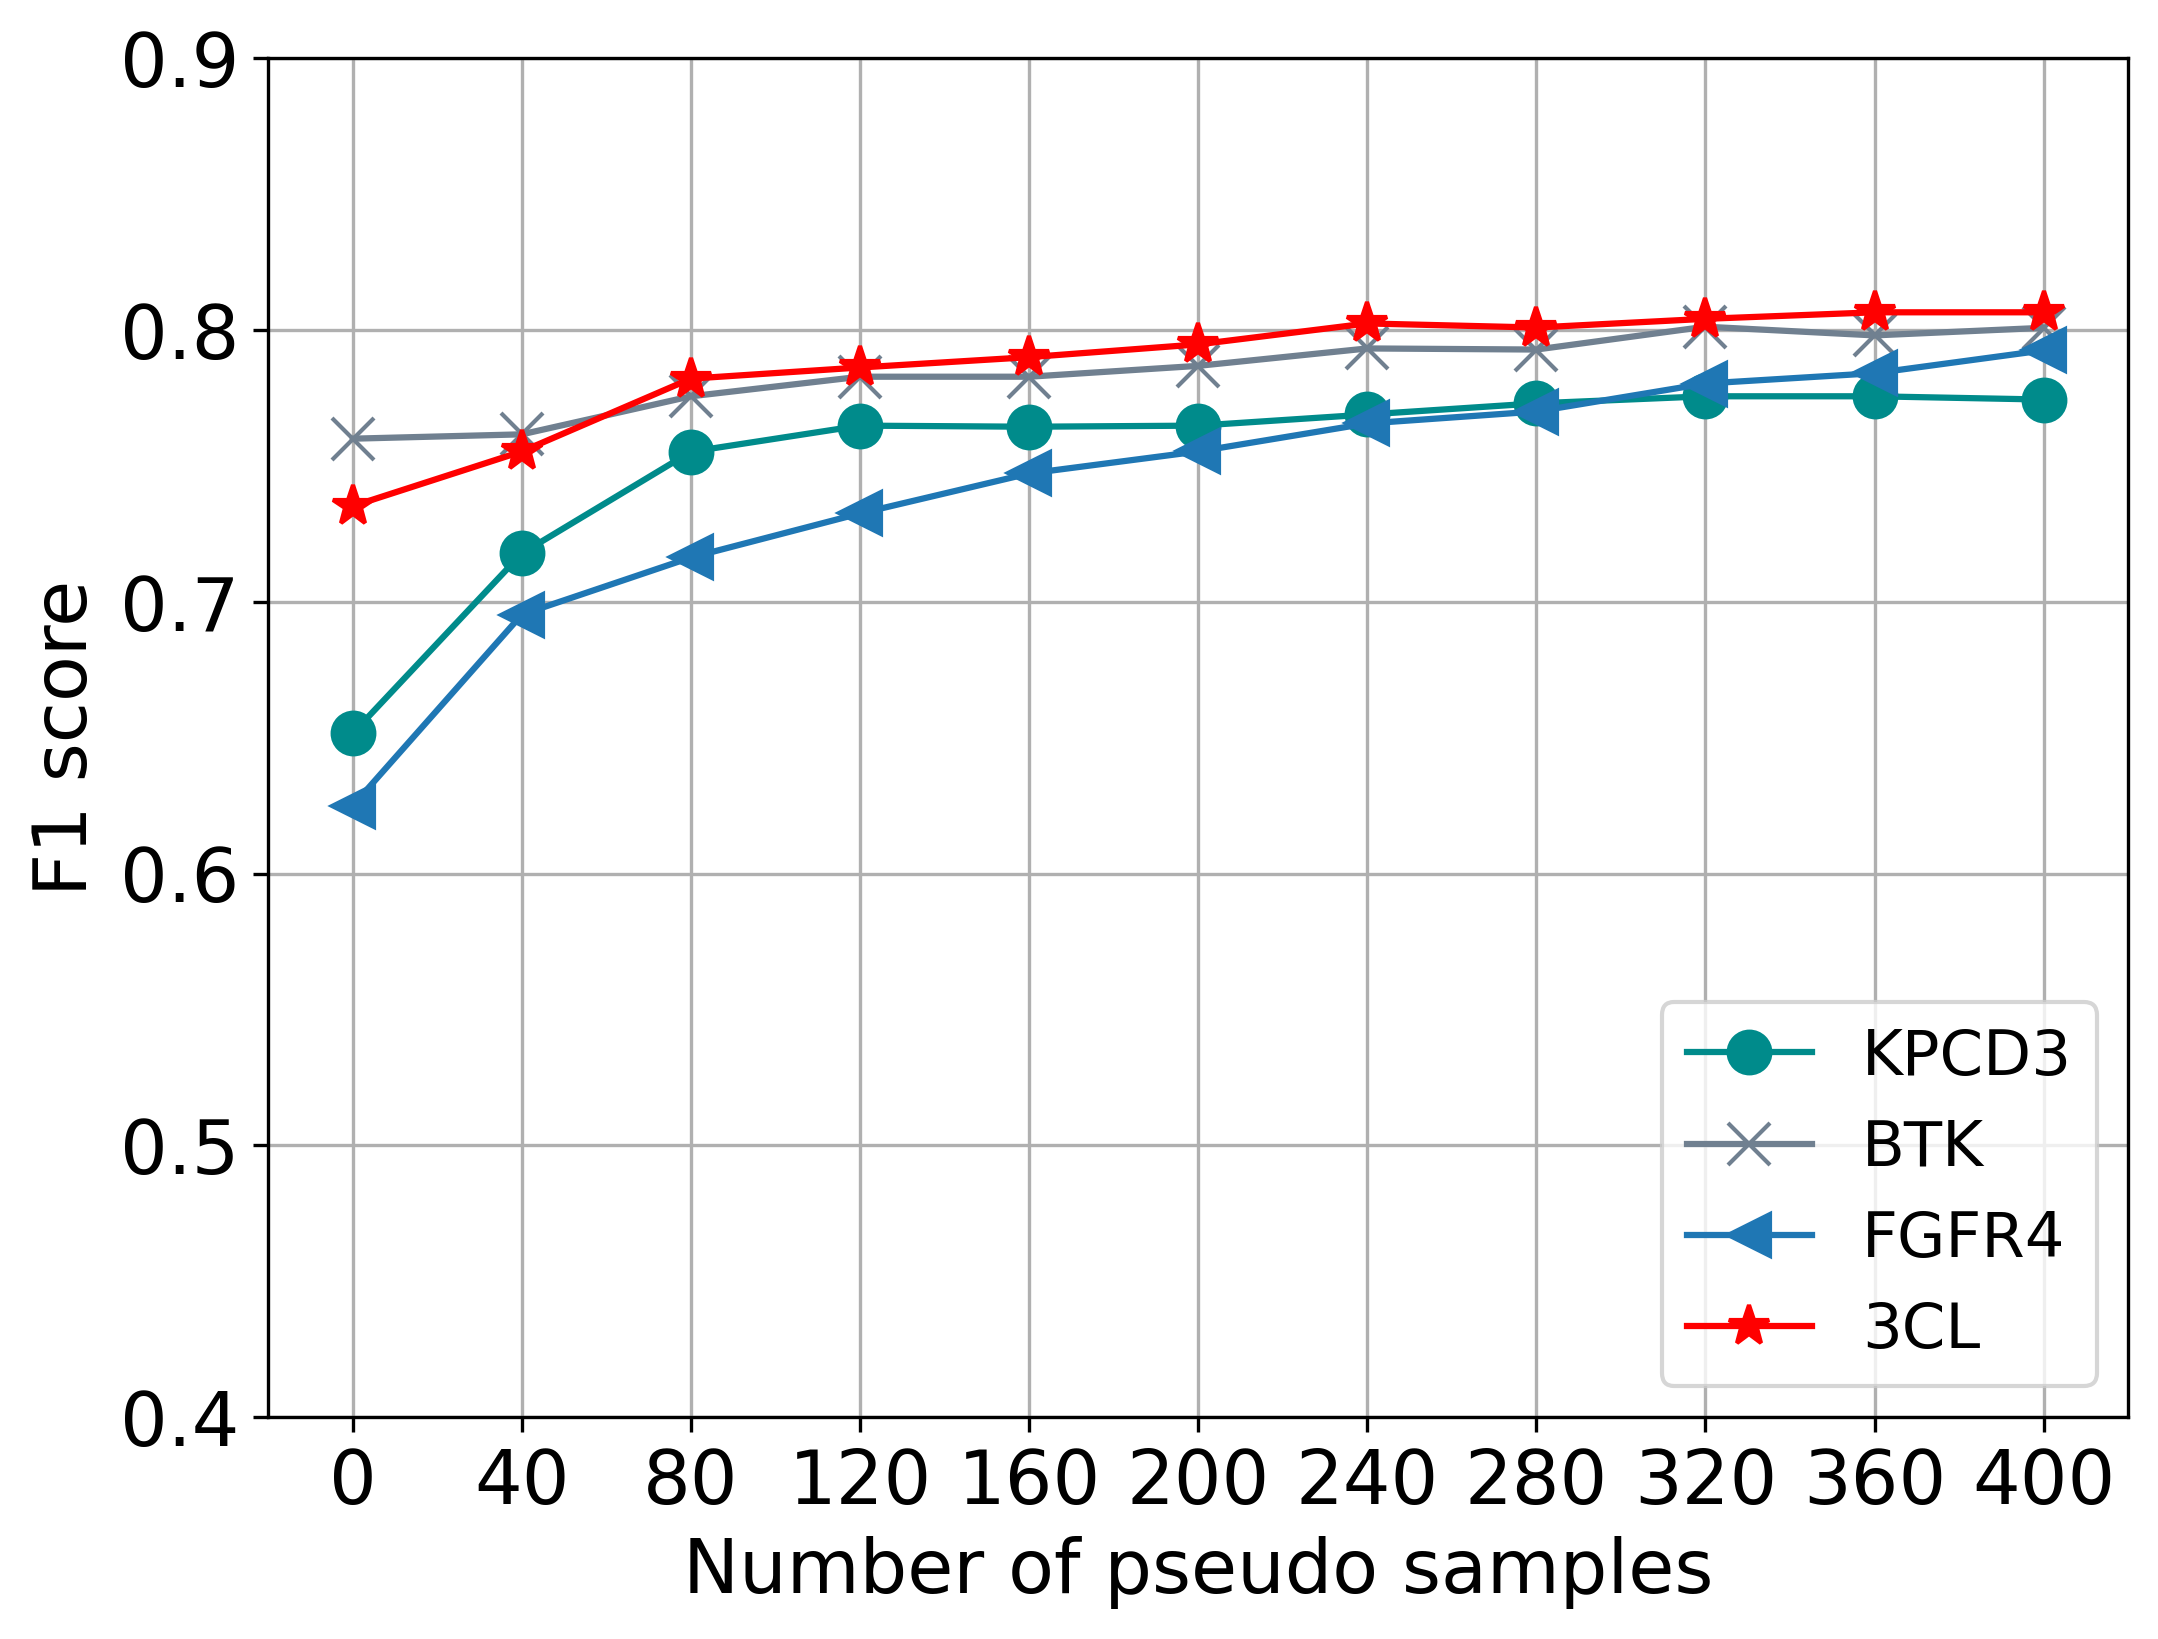

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

tmp = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
x = [i*2 for i in tmp]
x = np.array(x)

y_BTK = [0.7600]
y_BTK.extend(get_means('BTK'))
y_BTK = np.array(y_BTK)

y_KPCD3 = [0.6516]
y_KPCD3.extend(get_means('KPCD3'))
y_KPCD3 = np.array(y_KPCD3)

y_FGFR4 = [0.6250]
y_FGFR4.extend(get_means('FGFR4'))
y_FGFR4 = np.array(y_FGFR4)

y_3CL = [0.7352]
y_3CL.extend(get_means('3CL'))
y_3CL = np.array(y_3CL)

# idx = [i for i in range(21)]
idx = [0,2,4,6,8,10,12,14,16,18,20]

config = {
    "font.family":'serif',
    "font.size": 15,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'],
}


plt.figure(figsize=(8,6),dpi=300)
plt.grid()
# plt.rcParams['figure.figsize']=(5.5,5)
rcParams.update(config)

plt.xticks(x[idx])
plt.plot(x[idx],y_KPCD3[idx],label='KPCD3', marker='o', markersize=10, c='darkcyan')
plt.plot(x[idx],y_BTK[idx],label='BTK', marker='x', markersize=10, c='slategrey')
plt.plot(x[idx],y_FGFR4[idx],label='FGFR4', marker='<', markersize=10)
plt.plot(x[idx],y_3CL[idx],label='3CL', marker='*', markersize=10, c='red')

plt.tick_params(labelsize=18)
plt.xlabel('Number of pseudo samples',fontsize = 18)
plt.ylabel('F1 score',fontsize = 18)
plt.ylim(0.4,0.9)
plt.legend(loc='lower right')
# plt.title('Cora',fontsize = 18)
plt.savefig('./psudo.svg', bbox_inches='tight')
plt.savefig('./psudo.png', bbox_inches='tight')